# Time-LLM Paper Replicating

In this notebook, we're going to replicate the full TimeLLM architecture with a real LLM, DistilGPT2 (for fast experiments) with PyTorch: https://arxiv.org/abs/2310.01728.

## 0. Get setup

In [1]:
# Import libraries that are pre-installed in google colab
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

import transformers, accelerate
from transformers import AutoTokenizer, AutoModel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

from typing import List, Tuple, Dict, Callable, Optional

In [2]:
# Install torchinfo
try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo, installing it...")
  !pip3 install -q torchinfo
  from torchinfo import summary

[INFO] Couldn't find torchinfo, installing it...


In [3]:
# Setup device agnostic code
def set_device():
  if torch.cuda.is_available():
    device = "cuda"
  elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = "mps"
  else:
    device = "cpu"
  return device

DEVICE = set_device()
print(f"[INFO] Using device: {DEVICE}")

[INFO] Using device: cuda


## 1. Get data

For simplicity, we're going to create a toy dataset.

Now that our TimeLLM implementation is verified (see the previous notebook: https://github.com/chunyagi/ViTimeLLM/blob/main/timellm_paper_replicating.ipynb), let's test out the **prompt-as-prefix** mechanism by:

1. Extending the toy dataset to more than one cycle
2. Adding Gaussian noise to each time series

In [4]:
# For completeness
import numpy as np
import pandas as pd

# Set seed
np.random.seed(42)

# Setups of the toy dataset
PERIODS = 24 * 7 # 1 week per cycle
FREQ = "h" # sampling frequency
N_CYCLES = 5 # number of full cycles in the dataset
SIGMA = 0.2 # standard deviance of the gaussian noise

total_period = PERIODS * N_CYCLES # calculate the total number of periods in the dataset

# Create datatime index
dates = pd.date_range("2025-01-01", periods=total_period, freq=FREQ)

# Create sine and cosine curves (underlying DGP)
sin_curve = np.sin(np.linspace(0, 2 * np.pi * N_CYCLES, total_period))
cos_curve = np.cos(np.linspace(0, 2 * np.pi * N_CYCLES, total_period))

# Create gaussian noise
noise = np.random.normal(loc=0.0,
                         scale=SIGMA,
                         size=sin_curve.shape)

# Add gaussian noise to the data
sin_data = sin_curve + noise
cos_data = cos_curve + noise

# Create toy dataset
toy_df = pd.DataFrame(
    {"sin_data": sin_data,
     "cos_data": cos_data},
    index=dates
)
toy_df.head()

,sin_data,cos_data
2025-01-01 00:00:00,0.099343,1.099343
2025-01-01 01:00:00,0.009783,0.971646
2025-01-01 02:00:00,0.204357,1.126735
2025-01-01 03:00:00,0.416703,1.298303
2025-01-01 04:00:00,0.102388,0.941974


In [5]:
len(toy_df)

840

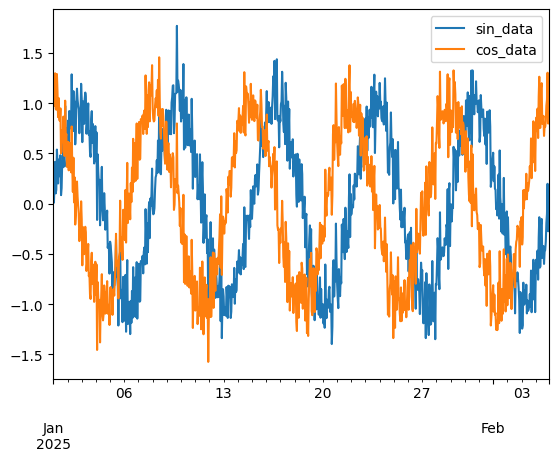

In [6]:
# Visualise data
toy_df.plot();

## 2. Create Datasets and DataLoaders

### 2.1 Split the data into training and test sets

In [7]:
# Let's split the data into training and test sets
train_split = int(len(toy_df) * 0.8) # 4 cycles for training, 1 cycle for testing
train_df = toy_df[:train_split]
test_df = toy_df[train_split:]
print(f"[INFO] Size of the training data: {len(train_df)}")
print(f"[INFO] Size of the test data: {len(test_df)}")

[INFO] Size of the training data: 672
[INFO] Size of the test data: 168


In [8]:
672 / 24

28.0

### 2.2 Create a custom PyTorch `Dataset` to replicate `TimeSeriesDataset` from PyTorch Forecasting

To create our own custom dataset, we want to:
1. Subclass `torch.utils.data.Dataset`.
2. Init our subclass with our target dataframe, (sliding) window size, forecast horizon, stride as well as a transform if we'd like to apply global transform (e.g. standardization) on our data (not necessary here).
3. Create several attributes:
* `df` - target dataset
* `window_size` - size of the sliding window, also called the history length (number of data points in the past the model uses to predict the future values)
* `forecast_horizon` - number of steps ahead the model wants to predict in the future
* `stride` - step size for sliding the input window across the time series
* `num_samples` - number of training samples
* `transform` - the (global) transform we'd like to use (not necessary here, just for completeness)
4. Overwrite the `__len__()` method to return the length of our dataset
5. Overwrite the `__getitem__()` method to return a given sample pair (in the form of a `Tuple`, `(input_window, target)`) when passed an index.

**Note:**
- Window size $\neq$ patch size! One input window could correspond to more than one patch!
- The `stride` here is not the same as the stride used in the time series patchification later!
- Given an index, want the `__getitem__()` method to return a tuple `(input_window, target)`
 - `input_window` is a tensor of shape `(number_of_channels, window_size)`
 - `target` is a tensor of shape `(number_of_channels, forcast_horizon)`, where `num_of_channels` means how many time series there are in the dataset.

> Remark: Some data points at the end of the series will be dropped when `(len(df) - window_size - forecast_horizon) % stride != 0`, because we don't have enough data points to form a complete (training/test) sample with the remaining data points. To make this problem minimal, try using overlapping sliding windows (i.e. `stride` < `window_size`).

In [9]:
# Write a custom dataset class and do the import
from torch.utils.data import Dataset
from typing import List, Tuple, Dict, Callable, Optional

# Subclass torch.utils.data.Dataset
class TimeSeriesDatasetCustom(Dataset):
  # Initialize our custom dataset
  def __init__(self,
               df: pd.DataFrame,
               window_size: int,
               forecast_horizon: int = 1,
               stride: int = 1,
               transform: Optional[Callable[[torch.tensor], torch.tensor]] = None): # not necessary, just for completeness
    super().__init__() # optinal here, but doesn't hurt

    # Create class attributes
    self.df = df
    self.window_size = window_size
    self.forecast_horizon = forecast_horizon
    self.stride = stride
    self.transform = transform

  # Overwrite __len__()
  def __len__(self) -> int:
    "Returns the total number of training samples."
    # Calcuate number of training samples
    num_samples = (len(self.df) - self.window_size - self.forecast_horizon) // self.stride + 1
    return num_samples

  # Overwrite __getitem__() method to return a particular sample pair (input_window, target)
  def __getitem__(self, index: int) -> Tuple[torch.tensor, torch.tensor]:
    "Returns one sample of data, data and label (x, y)."
    # Normalise negative indicies
    if index < 0:
      index = len(self) + index

    start = index * self.stride
    x = self.df[start: start + self.window_size].to_numpy()
    y = self.df[start + self.window_size: start + self.window_size + self.forecast_horizon].to_numpy()

    # Convert X & y to tensors
    x = torch.from_numpy(x).type(torch.float32) # convert the datatype from float64 (Numpy's default dtype) to float32 (PyTorch's default dtype)
    y = torch.from_numpy(y).type(torch.float32)

    # Change the output shape of x (pytorch prefers channel-first)
    if x.ndim == 1: # univariate time series data
      x = x.unsqueeze(dim=0) # add channel size
    else: # multivariate time series data
      x = x.transpose(0, 1) # channel first

    # Change the output shape of y as well
    if y.ndim == 1:
      y = y.unsqueeze(dim=0) # add channel size
    else:
      y = y.transpose(0, 1) # channel first

    # Transform if necessary
    if self.transform:
      return self.transform(x), y
    else:
      return x, y

In [10]:
# Test out TimeSeriesDatasetCustom
WINDOW_SIZE = 24 # one day of history
FORECAST_HORIZON = 1 # one-hour ahead prediction
STRIDE = 1 # overlapping window

train_data_custom = TimeSeriesDatasetCustom(df=train_df,
                                            window_size=WINDOW_SIZE,
                                            forecast_horizon=FORECAST_HORIZON,
                                            stride=STRIDE)
test_data_custom = TimeSeriesDatasetCustom(df=test_df,
                                           window_size=WINDOW_SIZE,
                                           forecast_horizon=FORECAST_HORIZON,
                                           stride=STRIDE)
train_data_custom, test_data_custom

(<__main__.TimeSeriesDatasetCustom at 0x7c2082c164d0>,
 <__main__.TimeSeriesDatasetCustom at 0x7c2082c15dd0>)

In [11]:
# Test out the __len__() method
# Print out some info about our dataset
print(f"[INFO] Size of the training dataset: {len(train_data_custom)}")
print(f"[INFO] Size of the test dataset: {len(test_data_custom)}")

[INFO] Size of the training dataset: 648
[INFO] Size of the test dataset: 144


In [12]:
# Verify the number of samples (size of the dataset - window_size - forecast_horizon) // stride + 1
len(train_data_custom) == (len(train_df) - WINDOW_SIZE - FORECAST_HORIZON) // STRIDE + 1, len(test_data_custom) == (len(test_df) - WINDOW_SIZE - FORECAST_HORIZON) // STRIDE + 1

(True, True)

In [13]:
# Print some more info to test out the __getitem__() method
dataset_dict = {"training": train_data_custom,
                "test": test_data_custom}

for split, dataset in dataset_dict.items():
  print(f"[INFO] Sample 0 of {split} set:")
  print(f"Data:\n{dataset[0][0]}")
  print(f"Shape: {dataset[0][0].shape}")
  print()
  print(f"Target:\n{dataset[0][1]}")
  print(f"Shape: {dataset[0][1].shape}")
  print("\n")

[INFO] Sample 0 of training set:
Data:
tensor([[0.0993, 0.0098, 0.2044, 0.4167, 0.1024, 0.1393, 0.5386, 0.4126, 0.2012,
         0.4392, 0.2731, 0.3072, 0.4828, 0.0851, 0.1556, 0.4201, 0.3613, 0.6573,
         0.4425, 0.3705, 0.9740, 0.6626, 0.7472, 0.4737],
        [1.0993, 0.9716, 1.1267, 1.2983, 0.9420, 0.9357, 1.2907, 1.1193, 0.8616,
         1.0523, 0.8380, 0.8232, 0.9491, 0.5012, 0.5207, 0.7339, 0.6233, 0.8670,
         0.5997, 0.4750, 1.0256, 0.6613, 0.6930, 0.3666]])
Shape: torch.Size([2, 24])

Target:
tensor([[0.6736],
        [0.5138]])
Shape: torch.Size([2, 1])


[INFO] Sample 0 of test set:
Data:
tensor([[-0.0386, -0.0069, -0.1768, -0.0138, -0.0433,  0.5659,  0.4390,  0.5422,
          0.4679,  0.1330,  0.2886,  0.5255,  0.2167,  0.6366,  0.4782,  0.4827,
          0.7306,  0.7071,  0.5750,  0.9072,  0.4862,  0.8518,  0.8724,  0.7159],
        [ 0.9310,  0.9234,  0.7130,  0.8343,  0.7618,  1.3270,  1.1549,  1.2120,
          1.0905,  0.7076,  0.8144,  1.0018,  0.6429,  1.01

### 2.2 Turn custom loaded time series data into DataLoader's

In [14]:
import os
from torch.utils.data import DataLoader

# Setup number of workers and batch size
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32

# Turn the custom pytorch Datasets into DataLoaders
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True,
                                     drop_last=False)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False, # no need to shuffle the test data
                                    drop_last=False)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7c2082c15a10>,
 <torch.utils.data.dataloader.DataLoader at 0x7c20933a1e90>)

In [15]:
# Print out some information of the custom dataloaders
print(f"[INFO] Train dataloader (custom) has: {len(train_dataloader_custom)} batches with number of samples: {BATCH_SIZE}")
print(f"[INFO] Test dataloader (custom) has: {len(test_dataloader_custom)} batches with number of samples: {BATCH_SIZE}")

[INFO] Train dataloader (custom) has: 21 batches with number of samples: 32
[INFO] Test dataloader (custom) has: 5 batches with number of samples: 32


In [16]:
# Get a sample from the custom train dataloader
input_window, target = next(iter(train_dataloader_custom))
input_window.shape, target.shape

(torch.Size([32, 2, 24]), torch.Size([32, 2, 1]))

In [17]:
# Calculate the shape of the last batch
shape_of_last_batch = (len(train_data_custom) % BATCH_SIZE, 2, WINDOW_SIZE)
shape_of_last_batch

(8, 2, 24)

## 3. Replicating TimeLLM: Overview

With the dataloader's ready, we can now proceed to replicate TimeLLM's model architecture. Before we start, it's a good practice to think about the **inputs** and **outputs**.

* Inputs - What goes into the model? A pair consisting of:
  * Input window: A segment of the time series with length `window_size`
    * Shape: `(batch_size, num_channels, window_size)`
    * E.g. `(32, 2, 48)` - 32 samples in a batch, 2 time series, window size of 48
  * Target values: The ground truth value we want our model to predict
    * Shape: `(batch_size, num_channels, forecast_horizon)`
    * E.g. `(32, 2, 24)` - 32 samples in a batch, 2 time series, 24 ground truth future values

* Outputs - What comes out of the model?
  * Predictions for future time steps
    * Shape: `(batch_size, forecast_horizon)`
    * E.g. `(32, 24)` - 32 samples in a batch, 24 predictions into the future
  
> Note: The shape of the model outpus doesn't have `num_channels` in the second dimension because our model processes each (univariate) time series subsequently.

### 3.1 TimeLLM overview: pieces of the puzzle

* Section 3 introduction + Figure 2: Paper objectives & model architecture overview
* Four components: The main four components which TimeLLM can be broken down into

#### The introduction of Section 3 outlines the objectives of this paper and provides an overview of the model architecture. Here are some snippets:

* Objective:
Our model architecture is depicted in Fig. 2. We focus on reprogramming an embedding-visible language foundation model, such as Llama (Touvron et al., 2023) and GPT-2 (Radford et al., 2019), for general time series forecasting without requiring any fine-tuning of the backbone model. Specifically, we consider the following problem: given a sequence of historical observations $\mathbf{X} \in \mathbb{R}^{N \times T}$ consisting of $N$ different 1-dimensional variables across $T$ time steps, we aim to reprogram a large language model $f(\cdot)$ to understand the input time series and accurately forecast the readings at $H$ future time steps, denoted by $\hat{\mathbf{Y}} \in \mathbb{R}^{N \times H}$, with the overall objective to minimize the mean squared error between the ground truths $\mathbf{Y}$ and predictions:
$$
\frac{1}{H} \sum_{h=1}^H \| \hat{Y}_h - Y_h \|_F^2
$$

* Model architecture overview:
Our method encompasses three main components:
  1. input transformation
  2. a pre-trained and frozen LLM
  3. output projection.
  
  Initially, a multivariate time series is partitioned into $N$ univariate time series, which are subsequently processed independently (Nie et al., 2023). The $i$-th series is denoted as $\mathbf{X}^{(i)} \in \mathbb{R}^{1 \times T}$ which undergoes normalization, patching, and embedding prior to being reprogrammed with learned text prototypes to align the source and target modalities. Then, we augment the LLM’s time series reasoning ability by prompting it together with reprogrammed patches to generate output representations, which are projected to the final forecasts $\hat{\mathbf{Y}}^{(i)} \in \mathbb{R}^{1 \times H}$.

#### Figure 2

  <img src="https://raw.githubusercontent.com/chunyagi/ViTimeLLM/main/figures/timellm_architecture.png" width=600 alt="figure 2 from timellm paper">

### Four components

#### Section 3.1 breaks TimeLLM into four components:

1. **Input Embedding:**
Each input channel $\mathbf{X}^{(i)}$ is first individually normalized to have zero mean and unit standard deviation via reversible instance normalization (RevIN) in mitigating the time series distribution shift (Kim et al., 2021). Then, we divide $\mathbf{X}^{(i)}$ into several consecutive overlapped or non-overlapped patches (Nie et al., 2023) with length $L_p$; thus the total number of input patches
is $P = \lfloor (T − L_p ) \rfloor + 2$, where $S$ denotes the horizontal sliding stride. The underlying motivations $S$
are two-fold: (1) better preserving local semantic information by aggregating local information into each patch and (2) serving as tokenization to form a compact sequence of input tokens, reducing
computational burdens. Given these patches $\mathbf{X}_P^{(i)} \in \mathbb{R}^{P \times L_p}$ , we embed them as $\mathbf{X}_P^{(i)} \in \mathbb{R}^{P \times d_m}$
adopting a simple linear layer as the patch embedder to create dimensions $d_m$.

In summary, it can be broken down into 3 steps:
1. Normalization: zero mean and unit std
2. Patchification: patchify the input into $P$ patches, each of length $L_p$
3. Embedding: embed the patches by a simple a linear layer to change their dimensions from $L_p$ to $d_m$

**Note:** There is a hidden step that is not mentioned above. Before normalization, we need to slide an input window across the time series to create input segments.

```python
# Input Embedding
# 1. Normalisation
print(x_input.shape) # (batch_size, num_channels, window_size)
mean = x_input.mean(dim=2, keepdim=True)
std = x_input.std(dim=2, keepdim=True)
x_input_normalized = (x_input - mean) / std

# 2./3. Patchification + Embedding
# We will use a Conv1d layer to patchify and embed the patches simultaneously
patcher = Conv1d(in_channels=num_channels,
out_channel=embedding_dim,
kernel_size=patch_size,
stride=patch_size, # non-overlapping patches
padding=0) # no padding

# Perform the forward pass
x_input_patched = patcher(x_input_normalized)
print(x_input_patched.shape) # (batch_size, embedding_dim, num_patches)
# Make sure the returned sequence embedding dimensions are in the right order
x_input_patched = x_input_patched.permute(0, 2, 1) # (batch_size, num_patches, embedding_dim)
```

2. **Patch Reprogramming**: To close this gap, we propose reprogramming $\hat{\mathbf{X}}_{P}^{(i)}$ using pre-trained word embeddings $\mathbf{E} \in \mathbb{R}^{V \times D}$ in the backbone, where $V$ is the vocabulary size. Nevertheless, there is no prior knowledge indicating which source tokens are directly relevant. Thus, simply leveraging $\mathbf{E}$ will result in large and potentially dense reprogramming space. A simple solution is to maintain a small collection of text prototypes by linearly probing $\mathbf{E}$, denoted as $\mathbf{E}^{\prime} \in \mathbb{R}^{V^{\prime} \times D}$, where $V^{\prime} \ll V$. An illustration is in Fig. 3(a). Text prototypes learn connecting language cues, e.g., "short up" (red lines) and "steady down" (blue lines), which are then combined to represent the local patch information (e.g., "short up then down steadily" for characterizing patch 5) without leaving the space where the language model is pre-trained. This approach is efficient and allows for the adaptive selection of relevant source information. To realize this, we employ a multi-head crossattention layer. Specifically, for each head $k=\{1, \cdots, K\}$, we define query matrices $\mathbf{Q}_{k}^{(i)}=\hat{\mathbf{X}}_{P}^{(i)} \mathbf{W}_{k}^{Q}$, key matrices $\mathbf{K}_{k}^{(i)}=\mathbf{E}^{\prime} \mathbf{W}_{k}^{K}$, and value matrices $\mathbf{V}_{k}^{(i)}=\mathbf{E}^{\prime} \mathbf{W}_{k}^{V}$, where $\mathbf{W}_{k}^{Q} \in \mathbb{R}^{d_{m} \times d}$ and $\mathbf{W}_{k}^{K}, \mathbf{W}_{k}^{V} \in \mathbb{R}^{D \times d}$. Specifically, $D$ is the hidden dimension of the backbone model, and $d=\left\lfloor\frac{d_{m}}{K}\right\rfloor$. Then, we have the operation to reprogram time series patches in each attention head defined as:
$$
\mathbf{Z}_{k}^{(i)}=\operatorname{ATTENTION}\left(\mathbf{Q}_{k}^{(i)}, \mathbf{K}_{k}^{(i)}, \mathbf{V}_{k}^{(i)}\right)=\operatorname{SOFTMAX}\left(\frac{\mathbf{Q}_{k}^{(i)} \mathbf{K}_{k}^{(i) \top}}{\sqrt{d_{k}}}\right) \mathbf{V}_{k}^{(i)}
$$

  By aggregating each $\mathbf{Z}_{k}^{(i)} \in \mathbb{R}^{P \times d}$ in every head, we obtain $\mathbf{Z}^{(i)} \in \mathbb{R}^{P \times d_{m}}$. This is then linearly projected to align the hidden dimensions with the backbone model, yielding $\mathbf{O}^{(i)} \in \mathbb{R}^{P \times D}$.

#### Figure 3(a)

  <img src="./figures/patch_reprogramming.png" width=500 alt="figure 3a from timellm paper">

In summary, it can be broken down into 3 steps:
1. Create text prototypes $\mathbf{E'} \in \mathbb{R}^{V' \times D} $ by running $\mathbf{E} \in \mathbb{R}^{V \times D}$ (the word embeddings in the backbone model) through a linear layer
2. Employ a multi-head attention crossattention layer on the time series patches (queries) and text prototypes (keys and values) to align the source and target modalities
3. Run the reprogrammed patches $\mathbf{Z}^{(i)} \in \mathbb{R}^{P \times D}$ through a linear layer to align with the backbone's hidden dimensions $D$.

In pseudocode:
```python
# 1. Create text prototypes
linear_layer_for_text_prototypes = nn.Linear(in_features=vocab_size, out_features=text_prototype_size)

text_prototypes = linear_layer_for_text_prototypes(llm_word_embeddings)

# 2. Reprogramming time series patches with multi-head cross attention with text prototypes
reprogrammed_patch_embeddings = multihead_cross_attention(query=patches, key=llm_embeddings, value=llm_embeddings)

# 3. Run the reprogrammed patches through a linear layer to align with the llm's hidden dimensions
linear_layer_for_llm_hidden_dim = nn.Linear(in_features=patch_embedding_dim, out_features=llm_hidden_dim)
reprogrammed_patch_embeddings = linear_layer_for_llm_hidden_dim(reprogrammed_patch)
```

3. **Prompt-as-Prefix:** Prompts act as prefixes to enrich the input context and guide the transformation of reprogrammed time series patches.

4. **Output Projection:** Upon packing and feedforwarding the prompt and patch embeddings $\mathbf{O}^{(i)}$ through the frozen LLM as shown in Fig. 2, we discard the prefixal part and obtain the output representations. Following this, we flatten and linear project them to derive the final forecasts $\hat{\mathbf{Y}}^{(i)}$.

In pseudocode:
```python
# Input of the backbone model
prefix = [token_0, token_1, ...]
reprogammed_patch_embeddings = [patch_0, patch_1, ...]
input_embeddings = prefix + reprogrammed_patch_embeddings

# Perform forward pass to the LLM
output_embeddings = LLM(input_embeddings)

# Drop the (contextualised) prefix embeddings
output_embeddings = output_embeddings[:, prefix_length:, :] # (batch_size, num_patches, embedding_dim)

# flatten and pass them to the final forecast layer
output_embeddings_flattened = torch.flatten(output_embeddings, start_dim=1) # (batch_size, num_patches * embedding_dim)

# Create the forecast head
forecast_layer = nn.Linear(in_features=num_patches*embedding_dim,
out_features=forecast_horizen) # number of steps ahead (H)

# Pass the embedding to the forecast layer
forecast = forecast_layer(out_embeddings_flattened)
```

## 4. Component 1: Normalise the input windows, patchify them and turn them into patch embeddings

Let's remind ourselves of the steps in component 1:

> In summary, it can be broken down into 3 steps:
1. Normalization: zero mean and unit std
2. Patchification: patchify the input into $P$ patches, each of length $L_p$
3. Embedding: embed the patches by a simple a linear layer to change their dimensions from $L_p$ to $d_m$

### 4.1 Normalise the input windows (RevIN)

Before we jump into turning the patch embedding layer into a PyTorch module, we need to create a PyTorch module for RevIN (normalisation/inverse-normalisation).

Note: Not only will RevIN normalises the input time series segments (to zero mean and unit variance), but it also allows additional (per channel) scaling and shifting:
> $x_\mathrm{norm} = \gamma \cdot
(\frac{x-\mu}{\sigma+\epsilon}) + \beta$

Let's try to set up an example:

In [18]:
# Create example values
batch_size = 2
num_channels = 2
window_size = 6

# Create an example batch of input windows
torch.manual_seed(42)
example_windows = torch.randint(10, size=(batch_size, num_channels, window_size)).type(torch.float32) # (batch size, num_channels, window_size)
print(f"Example input time window:\n{example_windows}\n")

# Calculate mean and std
mean = torch.mean(example_windows, dim=2, keepdim=True)
std = torch.std(example_windows, dim=2, keepdim=True)
print(f"Example mean:\n{mean}\n")
print(f"Example standard deviation:\n{std}")
print(f"Mean/std shape: {mean.shape}\n")

# Create gamma and beta
gamma = torch.randint(10, size=(1, num_channels, 1)) # batch size is set to 1 for broadcasting
beta = torch.randint(10, size=(1, num_channels, 1))
print(f"Gamma:\n{gamma}")
print(f"Beta:\n{beta}\n")

# Normalise the examples
normalised_example_windows = (example_windows - mean) / std
print(f"Normalised example input time widow:\n{normalised_example_windows}")
affine_normalised_example_windows = normalised_example_windows * gamma + beta
print(f"Affine normalised example input window:\n{affine_normalised_example_windows}")

Example input time window:
tensor([[[2., 7., 6., 4., 6., 5.],
         [0., 4., 0., 3., 8., 4.]],

        [[0., 4., 1., 2., 5., 5.],
         [7., 6., 9., 6., 3., 1.]]])

Example mean:
tensor([[[5.0000],
         [3.1667]],

        [[2.8333],
         [5.3333]]])

Example standard deviation:
tensor([[[1.7889],
         [2.9944]],

        [[2.1370],
         [2.8752]]])
Mean/std shape: torch.Size([2, 2, 1])

Gamma:
tensor([[[9],
         [3]]])
Beta:
tensor([[[1],
         [9]]])

Normalised example input time widow:
tensor([[[-1.6771,  1.1180,  0.5590, -0.5590,  0.5590,  0.0000],
         [-1.0575,  0.2783, -1.0575, -0.0557,  1.6141,  0.2783]],

        [[-1.3259,  0.5459, -0.8579, -0.3900,  1.0139,  1.0139],
         [ 0.5797,  0.2319,  1.2753,  0.2319, -0.8115, -1.5072]]])
Affine normalised example input window:
tensor([[[-14.0935,  11.0623,   6.0312,  -4.0312,   6.0312,   1.0000],
         [  5.8275,   9.8349,   5.8275,   8.8330,  13.8423,   9.8349]],

        [[-10.9327,   5.913

### 4.2 Turn RevIN into a PyTorch module

In [19]:
import torch
from torch import nn

class RevIN(nn.Module):
  """Reversible instance normalisation ("RevIN" for short) for time series segments.

  Args:
    num_channels (int): Number of channels/time series in the dataset.
    affine (bool): If True, apply a learnable per-channel scale and bias after normalisation.
    eps (float): A small constant added to the denominator for numerical stability (prevents division by zero).

  Returns:
    (torch.tensor): Normalised (and linear transformed) input time series segments.
  """
  def __init__(self,
               num_channels: int,
               affine: bool = False, # whether you want an affine transformation after the standard normalisation or not
               eps: float = 1e-5): # added to the denominator to prevent division by zero error
    super().__init__()

    self.affine = affine
    self.eps = eps

    if affine:
      self.gamma = nn.Parameter(torch.ones(1, num_channels, 1),
                                requires_grad=True) # make sure it's learnable
      self.beta = nn.Parameter(torch.zeros(1, num_channels, 1),
                               requires_grad=True)

  def forward(self, x):
    # Calculate the mean and variance of the input segments
    self.mean = torch.mean(x, dim=2, keepdim=True) # set keepdim to True to keep the second dimension
    self.std = torch.std(x, dim=2, keepdim=True)

    # Normalise it to have zero mean and unit variance
    x_norm = (x - self.mean) / (self.std + self.eps)

    # If affine is enabled, learn a linear transformation as well
    if self.affine:
      x_norm = self.gamma * x_norm + self.beta

    return x_norm

  # Inverse normalisation to convert the input segments back to their original scale
  def inverse(self, x_norm):
    if self.affine:
      # Reverse the linear transformation process
      x_norm = (x_norm - self.beta) / (self.gamma + self.eps)

    # Reverse normalisation
    x = x_norm * self.std + self.mean

    return x

In [20]:
example_windows.shape

torch.Size([2, 2, 6])

In [21]:
# Test the RevIN class
# Create an instance of RevIN layer
revin_layer = RevIN(num_channels=2,
                    affine=True)

# Pass example windows through RevIN layer
print(f"Input time series windows:\n{example_windows}\n") # add an extra batch dimension
revin_example_windows = revin_layer(example_windows)
print(f"Output normalised time series windows:\n{revin_example_windows}\n")
inverse_revin_example_windows = revin_layer.inverse(revin_example_windows)
print(f"Output inverse normalised time series windows:\n{inverse_revin_example_windows}")

Input time series windows:
tensor([[[2., 7., 6., 4., 6., 5.],
         [0., 4., 0., 3., 8., 4.]],

        [[0., 4., 1., 2., 5., 5.],
         [7., 6., 9., 6., 3., 1.]]])

Output normalised time series windows:
tensor([[[-1.6770,  1.1180,  0.5590, -0.5590,  0.5590,  0.0000],
         [-1.0575,  0.2783, -1.0575, -0.0557,  1.6141,  0.2783]],

        [[-1.3259,  0.5459, -0.8579, -0.3900,  1.0139,  1.0139],
         [ 0.5797,  0.2319,  1.2753,  0.2319, -0.8115, -1.5071]]],
       grad_fn=<AddBackward0>)

Output inverse normalised time series windows:
tensor([[[2.0000e+00, 7.0000e+00, 6.0000e+00, 4.0000e+00, 6.0000e+00,
          5.0000e+00],
         [4.2439e-05, 4.0000e+00, 4.2439e-05, 3.0000e+00, 7.9999e+00,
          4.0000e+00]],

        [[4.1485e-05, 4.0000e+00, 1.0000e+00, 2.0000e+00, 5.0000e+00,
          5.0000e+00],
         [7.0000e+00, 6.0000e+00, 9.0000e+00, 6.0000e+00, 3.0000e+00,
          1.0001e+00]]], grad_fn=<AddBackward0>)


### 4.3 Calculate input and output shapes of the patch embedding layer by hand

Batch size is omitted for simplicity here

* Input shape: $N \times W$ (number of channels/time series x window size)
* Output shape: $P \times d_m$ (number of patches x hidden dimension of the patch embeddings)

In [22]:
# Create example values
input_window_size = 6 # window size (W)
num_of_channels = 2 # number of time series in the dataset (N)
patch_size = 2 # patch length (L_p)
non_overlap_stride = 2 # produce non-overlapping patches
overlap_stride = 1 # produce overlapping patches
patch_embedding_dim = 768 # patch embeddings dimension (d_m)

# Calculate the number of patches (P) with non-overlapping stride (assumed no padding)
number_of_non_overlap_patches = (input_window_size - patch_size) // non_overlap_stride + 1
print(f"Number of patches with non-overlapping stride {non_overlap_stride}: {number_of_non_overlap_patches}")

# Calculate the number of pacthes (P) with overlapping stride
number_of_overlap_patches = (input_window_size - patch_size) // overlap_stride + 1
print(f"Number of patches with overlapping stride {overlap_stride}: {number_of_overlap_patches}")

Number of patches with non-overlapping stride 2: 3
Number of patches with overlapping stride 1: 5


In [23]:
# Input shape
patch_embedding_layer_input_shape = (num_of_channels, input_window_size)

# Output shape (assumed non-overlapping stride)
patch_embedding_layer_output_shape = (number_of_non_overlap_patches, patch_embedding_dim)

print(f"Input shape ({num_of_channels} input windows): {patch_embedding_layer_input_shape}")
print(f"Output shape (1 sequence of non-overlapping patches): {patch_embedding_layer_output_shape}")

Input shape (2 input windows): (2, 6)
Output shape (1 sequence of non-overlapping patches): (3, 768)


### 4.4  Creating time series patches and turning them into patch embeddings

> Note:
The embedding method used in this implementation is probably different from the one stated in the paper. In the paper, a multivariate time series is first **partitioned into N univariate time series, which are subsequently processed independently.** But here we used a 1D convolutional layer to embed the information across all the time series **at once** into the patch embeddings. This may require a higher hidden dimension ($d_m$) to capture to capture more information from the other time series (therefore higher compute cost), but it streamlines the data flow pipeline.

In [24]:
# Create a conv1d layer to turn the time series input window into patches of learnable embeddings (patchification and embedding at the same time)
from torch import nn

# Set up the patch size (L_p)
patch_size = 2

conv1d = nn.Conv1d(in_channels=2, # number of time series
                   out_channels=768, # patch embedding dimension
                   kernel_size=patch_size,
                   stride=patch_size, # non-overlapping patches
                   padding=0) # no padding
conv1d

Conv1d(2, 768, kernel_size=(2,), stride=(2,))

In [25]:
# Get a training sample
input_window = train_data_custom[0][0]

# Remind ourselves of what the data looks like
print(f"[INFO] Input data:\n{input_window}") # take the first batch
print(f"[INFO] Shape: {input_window.shape}")

[INFO] Input data:
tensor([[0.0993, 0.0098, 0.2044, 0.4167, 0.1024, 0.1393, 0.5386, 0.4126, 0.2012,
         0.4392, 0.2731, 0.3072, 0.4828, 0.0851, 0.1556, 0.4201, 0.3613, 0.6573,
         0.4425, 0.3705, 0.9740, 0.6626, 0.7472, 0.4737],
        [1.0993, 0.9716, 1.1267, 1.2983, 0.9420, 0.9357, 1.2907, 1.1193, 0.8616,
         1.0523, 0.8380, 0.8232, 0.9491, 0.5012, 0.5207, 0.7339, 0.6233, 0.8670,
         0.5997, 0.4750, 1.0256, 0.6613, 0.6930, 0.3666]])
[INFO] Shape: torch.Size([2, 24])


In [26]:
# Pass the input window through the convolutional layer
input_window_out_of_conv = conv1d(input_window.unsqueeze(dim=0)) # add batch dimension
input_window_out_of_conv, input_window_out_of_conv.shape

(tensor([[[ 0.1428, -0.1795,  0.0232,  ..., -0.0337, -0.0398,  0.0178],
          [ 0.3224,  0.4933,  0.3488,  ...,  0.4125,  0.6304,  0.4901],
          [-0.5688, -0.4462, -0.5192,  ..., -0.3453, -0.1920, -0.2577],
          ...,
          [ 0.1249,  0.1354,  0.1107,  ...,  0.1572,  0.2963,  0.2290],
          [ 0.4883,  0.6543,  0.4701,  ...,  0.3133,  0.4965,  0.3175],
          [-0.1781, -0.0329, -0.0865,  ..., -0.1260, -0.3778, -0.2800]]],
        grad_fn=<ConvolutionBackward0>),
 torch.Size([1, 768, 12]))

In [27]:
input_window_out_of_conv.requires_grad # make sure it's learnable

True

Let's interpret the shape of the output tensor. 1 is the batch size, 768 means, for each patch in the 1x12 grid, it has its own embeddings of 768 dimensions.

Let's plot some random dimensions of the patch embeddings and see what they look like:

In [28]:
# Plot random convolutional feature maps (embeddings)
import random

# Set seed
random.seed(42)

# Draw 5 random embedding dimensions
random_indexes = random.sample(range(0, 768), k=5)
print(f"Showing random convolutional feature maps from indexes {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(7, 7))

# Plot random input window feature maps
for i, idx in enumerate(random_indexes):
  input_window_feature_map = input_window_out_of_conv[:, idx, :]
  axs[i].imshow(input_window_feature_map.detach().numpy()) # remove gradient tracking and convert it to numpy array
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

Showing random convolutional feature maps from indexes [654, 114, 25, 759, 281]


In [29]:
# Get a single feature map in tensor form
single_feature_map = input_window_out_of_conv[:, 654, :]
single_feature_map, single_feature_map.shape # brighter color means the embedding value is larger

(tensor([[-1.0735, -1.1537, -0.9879, -1.2763, -0.9819, -0.9511, -1.0027, -0.7532,
          -0.8642, -0.8123, -1.1591, -0.9035]], grad_fn=<SliceBackward0>),
 torch.Size([1, 12]))

### 4.5 Permute the patch embeddings to make sure the embedding dimension is in the right order

Right now, the shape of the output tensor from the conv1d layer is `(1, 768, 3)`, which is not what we want. We want the embedding dimension to be the last dimension: `(1, 3, 768)`.

In [30]:
# Rearrange the dimension of the output tensor from conv1d
patch_embeddings = input_window_out_of_conv.permute(0, 2, 1)
patch_embeddings.shape

torch.Size([1, 12, 768])

### 4.6 Turning the patch embedding layer into a PyTorch module

We want this module to do a few things:
1. Create a layer to turn time series segments into embedding patches using `nn.Conv1d()`
2. Permute the patch embeddings dimension, i.e. `(batch_size, num_patches, embedding_dim)`

In [31]:
from torch import nn

class PatchEmbedding(nn.Module):
  """
  Create (multivariate) time series patches and embed the patches.

  Args:
    num_channels (int): Number of time series in the dataset.
    patch_size (int): Length of the time series patches.
    stride (int): Step size for sliding the kernel across the time series.
    embedding_dim (int): Patch Embedding dimensions.
    padding (int): Number of paddings added to the beginning and the end of the input time series windows.

  Returns:
    (torch.tensor) Time series patch embeddings
  """
  def __init__(self,
               num_channels: int, # number of time series in the dataset (N)
               patch_size: int, # patch length (L_p)
               stride, # number of steps the kernel moves along the input window
               embedding_dim: int = 16, # embedding dimension of the patch embeddings
               padding: int = 0): # paddings added to both sides of the input window before convolutions
    super().__init__()

    # Create a layer to turn a time series input window into embedded patches
    self.patcher = nn.Conv1d(in_channels=num_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=stride,
                             padding=padding)

    self.patch_size = patch_size
    self.stride = stride
    self.padding = padding

  def forward(self, x):
    # Check if patch size is compatible with the input window size and stride
    input_window_size = x.shape[-1]
    if (input_window_size + 2*self.padding - self.patch_size) % self.stride != 0:
      print("Warning: Input window size is incompatible with the given patch size and stride. The last few time steps will be dropped.") # can turn this into a warning

    # Patchify the input windows and embed the patches
    x_patched = self.patcher(x)

    # Rearrange the dimension of the patches
    return x_patched.permute(0, 2, 1)

**Note:**

The `padding` parameter in `PatchEmbedding` serves two purposes:
1. Allows early and late steps to participate in more patches (get convolved a few more times), improving representations at boundaries.
2. Prevents truncation by making the input window size `L_p` compatibe with the given patch size `P` and stride `S`.

However, it doesn't support asymmetric padding right now (can work on it later with `F.pad`).

In [32]:
input_window

tensor([[0.0993, 0.0098, 0.2044, 0.4167, 0.1024, 0.1393, 0.5386, 0.4126, 0.2012,
         0.4392, 0.2731, 0.3072, 0.4828, 0.0851, 0.1556, 0.4201, 0.3613, 0.6573,
         0.4425, 0.3705, 0.9740, 0.6626, 0.7472, 0.4737],
        [1.0993, 0.9716, 1.1267, 1.2983, 0.9420, 0.9357, 1.2907, 1.1193, 0.8616,
         1.0523, 0.8380, 0.8232, 0.9491, 0.5012, 0.5207, 0.7339, 0.6233, 0.8670,
         0.5997, 0.4750, 1.0256, 0.6613, 0.6930, 0.3666]])

In [33]:
# Test the PatchEmbedding class

# Add an extra batch dimension to input_window (the first sample in training dataloader)
batchified_input_window = input_window.unsqueeze(dim=0)

# Create an instance of a non-overlapping patch embedding layer
non_overlap_patchify = PatchEmbedding(num_channels=2,
                                      patch_size=2,
                                      stride=2,
                                      embedding_dim=768,
                                      padding=0)

# Pass a training example through patch embedding layer
print(f"Input sample size: {batchified_input_window.shape}")
patch_embedded_input_window = non_overlap_patchify(batchified_input_window)
print(f"Output patch embeddings shape: {patch_embedded_input_window.shape}")

Input sample size: torch.Size([1, 2, 24])
Output patch embeddings shape: torch.Size([1, 12, 768])


In [34]:
# Create an instance of an overlapping patch embedding layer
overlap_patchify = PatchEmbedding(num_channels=2,
                                  patch_size=2,
                                  stride=1, # overlapping patch
                                  embedding_dim=768,
                                  padding=0)

# Pass a training example through patch embedding layer
print(f"Input sample size: {batchified_input_window.shape}")
patch_embedded_input_window = overlap_patchify(batchified_input_window)
print(f"Output patch embeddings shape: {patch_embedded_input_window.shape}")

Input sample size: torch.Size([1, 2, 24])
Output patch embeddings shape: torch.Size([1, 23, 768])


In [35]:
# Create an example training sample to show how paddings can help prevent truncation
example_long_windows = torch.randint(10, size=(2, 2, 26)).type(torch.float32)

# Create an instance of a patch embedding layer with no padding
no_pad_patchify = PatchEmbedding(num_channels=2,
                                 patch_size=7,
                                 stride=7,
                                 embedding_dim=768,
                                 padding=0) # no padding

print(f"Input sample size: {example_long_windows.shape}")
patch_embedded_example_long_windows_no_pad = no_pad_patchify(example_long_windows)
print(f"Output patch embeddings shape before padding: {patch_embedded_example_long_windows_no_pad.shape}")

# Create an instance of a patch embedding layer with padding
padded_patchify = PatchEmbedding(num_channels=2,
                                 patch_size=7,
                                 stride=7,
                                 embedding_dim=768,
                                 padding=1) # add padding to the beginning and the end of the input
patch_embedded_example_long_windows_with_pad = padded_patchify(example_long_windows)
print(f"Output patch embeddings shape after padding: {patch_embedded_example_long_windows_with_pad.shape}")

Input sample size: torch.Size([2, 2, 26])
Output patch embeddings shape before padding: torch.Size([2, 3, 768])
Output patch embeddings shape after padding: torch.Size([2, 4, 768])


## Component 2: Patch Reprogramming

To reprogram the time-series patches, we need access to LLaMA’s pre-trained word embeddings.

### Create a function to load a pretrained tokenizer, model and its embedding layer

In [36]:
from typing import Optional, Union, Dict

from transformers import AutoTokenizer, AutoModel

def load_llm_backbone(checkpoint: str = "huggyllama/llama-7b", # use llama-7b by default
                      use_fast: bool = True, # enables fast implementation, but requires Rust installed
                      padding_side: str = "left", # the side where padding starts
                      torch_dtype: torch.dtype = torch.float16, # model weights datatype
                      device_map: Optional[Union[str, Dict[str, str]]] = None, # don't let accelerate decide where to put the shards automatically
                      low_cpu_mem_usage: bool = True): # avoid ever holding the entire fp32 model (with casted copy) in cpu ram
                      # device: torch.device = DEVICE): # where to move the model to if device_map is set to None
  """
  Loads a pretrained tokenizer, model and its embedding layer from Hugging Face transformers.

  Args:
    checkpoint (str): The model checkpoint you want to load.
    use_fast (bool): If set to True, it will enable fast implementation for the tokenizer. Note: It requires Rust to be installed.
    padding_side (str): The side where padding starts.
    torch_dtype (torch.dtype): Model weights datatype in which you want to load.
    device_map (Optional[Union[Dict[str, str]]]): It tells Accelerate where to put each checkpoint shard (GPU or CPU offload).
    low_cpu_mem_usage (bool): If set to True, it enables the empty-weights mechanism (creating meta tensors instead of making a full
      fp32 copy in CPU RAM).
    device (torch.device): The fallback device to move the model to if `device_map` is `None`.

  Returns:
    Pretrained tokenizer, model and its embedding layer.
  """
  # Load the pretrained tokenizer
  tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=checkpoint,
                                            use_fast=use_fast)

  # Check if there's a pad token in the tokenizer to enable batch processing
  if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token # use the <EOS> token for padding if there is no padding token
    tokenizer.padding_side = padding_side # "left" for autoregressive models

  # Load the pretrained model
  model = AutoModel.from_pretrained(
      pretrained_model_name_or_path=checkpoint,
      torch_dtype=torch_dtype,
      device_map=device_map,
      low_cpu_mem_usage=low_cpu_mem_usage
  )

  # Set the model to eval mode
  model.eval()

  # Freeze all of the model's layers
  for param in model.parameters():
    param.requires_grad = False

  # Move the model to the target device manually if there is no input device map
  # if device_map is None:
  #   model.to(device)

  # Get the model's embedding layer
  embedding_layer = model.get_input_embeddings()

  return tokenizer, model, embedding_layer

In [37]:
# Test the function
tokenizer, llm_model, llm_embedding_layer = load_llm_backbone(checkpoint="distilgpt2",
                                                              torch_dtype=torch.float32)
# Move the model to the gpu
llm_model.to(DEVICE)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-5): 6 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [38]:
# Inspect the llm's pretrained embedding layer
print(f"[INFO] LLM's pretrained embedding layer: {llm_embedding_layer.weight}")
print(f"[INFO] Shape of the LLM's pretrained embedding layer: {llm_embedding_layer.weight.shape}")
print(f"[INFO] Datatype of the LLM's pretrained embedding layer: {llm_embedding_layer.weight.dtype}")
print(f"[INFO] The pretrained embedding layer has {llm_embedding_layer.weight.shape[0]} vocabs and each of the embedding has {llm_embedding_layer.weight.shape[1]} dimensions")

[INFO] LLM's pretrained embedding layer: Parameter containing:
tensor([[-0.1445, -0.0455,  0.0042,  ..., -0.1523,  0.0184,  0.0991],
        [ 0.0573, -0.0722,  0.0234,  ...,  0.0603, -0.0042,  0.0478],
        [-0.1106,  0.0386,  0.1948,  ...,  0.0421, -0.1141, -0.1455],
        ...,
        [-0.0710, -0.0173,  0.0176,  ...,  0.0834,  0.1340, -0.0746],
        [ 0.1993,  0.0201,  0.0151,  ..., -0.0829,  0.0750, -0.0294],
        [ 0.0342,  0.0640,  0.0305,  ...,  0.0291,  0.0942,  0.0639]],
       device='cuda:0')
[INFO] Shape of the LLM's pretrained embedding layer: torch.Size([50257, 768])
[INFO] Datatype of the LLM's pretrained embedding layer: torch.float32
[INFO] The pretrained embedding layer has 50257 vocabs and each of the embedding has 768 dimensions


Now we can move on to the patch reprogramming layer:

Steps:
1. Pass the LLM's pretrained embedding layer through a linear layer to learn text prototypes (from vocab size $V$ to text prototype size $V'$, where $V' << V$)
3. Pass the text prototypes through another linear layer to project them from hidden size $D$ to the patch embedding dimension $d_{m}$
4. Cross attention between the patch embeddings (queries) and the learnt text prototypes (keys and values)
5. Run the reprogrammed patch embeddings through a final linear layer to align with the LLM's hidden dimension $D$

In [39]:
class PatchReprogramming(nn.Module):
  """
  Reprogram the time series patch embeddings with text prototypes before feeding
  them into the frozen LLM to align the two different modalities (time series and text).

  Args:
    pretrained_word_embeddings (torch.nn.modules.sparse.Embedding): Backbone model's pretrained word embeddings.
    num_heads (int): Number of attention heads.
    vocab_size (int): Number of vocabularies in the LLM's tokenizer.
    text_prototype_size (int): Number of text prototypes.
    hidden_size (int): Hidden dimension of the word embeddings used in the frozen LLM (D).
    embedding_dim (int): Embedding dimension of the patch embeddings (d_m).
    attn_dropout (float): Dropout layer used in the multi-head attention layer.

  Returns:
    (torch.tensor) Reprogrammed time series patch embeddings with hidden size
    aligned with the frozen LLM (D).
  """
  def __init__(self,
               pretrained_word_embeddings: torch.nn.modules.sparse.Embedding, # backbone model's pretrained word embeddings
               num_heads: int, # number of attention heads
               vocab_size: int = 500, # number of vocabs
               text_prototype_size: int = 100, # number of text prototypes
               hidden_size: int = 512, # hidden size of pretrained word embeddings
               embedding_dim: int = 768, # embedding dimension of patch embeddings
               attn_dropout: float = 0): # dropout layer used in attention
    super().__init__()

    self.pretrained_word_embeddings = pretrained_word_embeddings

    # Create a linear layer to learn text prototypes from the pretrained word embeddings (V -> V')
    self.text_prototype_linear_layer = nn.Linear(in_features=vocab_size,
                                                 out_features=text_prototype_size)

    # Create a linear layer to project the text prototypes to the same dimension as the patch embeddings (D -> d_m)
    self.text_prototype_to_patch_embedding_layer = nn.Linear(in_features=hidden_size,
                                                             out_features=embedding_dim)

    # Create multi-head cross-attention layer
    self.cross_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                            num_heads=num_heads,
                                            dropout=attn_dropout,
                                            batch_first=True) # use batch size as the first dimension (batch_size, num_patches, embedding_dim)

    # Create a linear layer to align the reprogrammed patch embeddings with the LLM's hidden size (d_m -> D)
    self.patch_embedding_to_llm_token_layer = nn.Linear(in_features=embedding_dim,
                                                        out_features=hidden_size)

  def forward(self, x):
    # Get the weights of the pretrained word embeddings and add an extra batch size dimension
    pretrained_word_embeddings = self.pretrained_word_embeddings.weight.unsqueeze(dim=0).expand(x.shape[0], -1, -1) # shape: (batch_size, vocab_size, hidden_size)

    # Learn text prototypes
    text_prototypes = self.text_prototype_linear_layer(pretrained_word_embeddings.permute(0, 2, 1)) # permute the dimensions of pretrained word embeddings so that vocab size is last: (batch_size, hidden_size, vocab_size)

    # Project them onto the same dimension that the patch embeddings are living in
    text_prototypes = self.text_prototype_to_patch_embedding_layer(text_prototypes.permute(0, 2, 1)) # permute the dimensions again so that the hidden size is last: (batch_size, vocab_size, hidden_size)

    # Cross-attention between text prototypes and patch embeddings
    attn_output, _ = self.cross_attn(query=x,
                                     key=text_prototypes,
                                     value=text_prototypes,
                                     need_weights=False)

    # Project the attention output (reprogrammed patch embeddings) to the LLM's hidden size
    return self.patch_embedding_to_llm_token_layer(attn_output)

In [40]:
# Test if it works
print(f"Patch embeddings shape: {patch_embeddings.shape}\n")

# Create an instance of PatchReprogamming layer
patch_reprogramming_layer = PatchReprogramming(pretrained_word_embeddings=llm_embedding_layer,
                                               num_heads=12, # number of attention heads
                                               vocab_size=llm_embedding_layer.weight.shape[0], # vocab size of the backbone model
                                               hidden_size=llm_embedding_layer.weight.shape[1]) # hidden/embedding dimension used in the backbone model

# Move the patch reprogramming layer to gpu because our pretrained word embeddings live in the gpu
patch_reprogramming_layer.to(DEVICE)

# Reprogram the patch embeddings
reprogrammed_patch_embeddings = patch_reprogramming_layer(patch_embeddings.to(DEVICE)) # move patch embeddings to the gpu as well
print(f"Reprogrammed patch embeddings:\n{reprogrammed_patch_embeddings}")
print(f"Shape (batch_size, num_patches, embedding_dim) -> (batch_size, num_patches, hidden_size): {reprogrammed_patch_embeddings.shape}")

Patch embeddings shape: torch.Size([1, 12, 768])

Reprogrammed patch embeddings:
tensor([[[-0.0002,  0.0313,  0.0013,  ...,  0.0109, -0.0288,  0.0342],
         [-0.0002,  0.0313,  0.0013,  ...,  0.0109, -0.0288,  0.0342],
         [-0.0002,  0.0313,  0.0013,  ...,  0.0109, -0.0288,  0.0342],
         ...,
         [-0.0002,  0.0313,  0.0013,  ...,  0.0109, -0.0288,  0.0342],
         [-0.0002,  0.0312,  0.0013,  ...,  0.0109, -0.0288,  0.0342],
         [-0.0002,  0.0313,  0.0013,  ...,  0.0109, -0.0288,  0.0342]]],
       device='cuda:0', grad_fn=<ViewBackward0>)
Shape (batch_size, num_patches, embedding_dim) -> (batch_size, num_patches, hidden_size): torch.Size([1, 12, 768])


## Component 3: Prompt-as-Prefix

Now with the tokenizer loaded from Hugging Face, we can try to write some prompt as prefix to the LLM.

Figure 4 gives us a prompt example:  

#### Figure 4

  <img src="./figures/example_prompt.png" width=500 alt="figure 4 from timellm paper">

> Note: For now, we assume the prompt to be **static** (same prompt will be reused across all batches) for simplicity. But later we can also explore **dynamic** prompts (varied across batches).

In [76]:
# Setup window size and forecast horizon
WINDOW_SIZE = 24
FORECAST_HORIZON = 1

# Create prompt as prefix to the LLM
prompt_as_prefix = f"""This toy multivariate time series dataset is designed to validate the TimeLLM architecture. \
It has two channels - standard sine and cosine waves with additive Gaussian noise (as the sampling noise), \
sampled hourly over five weeks (840 points total, spanning 5 full 0 to 2pi cycles). The dataset is split into: \
- Training: 4 weekly cycles (80% of data, 672 points)
- Test: 1 weekly cycle (20% of data, 168 points).
Below is the information about the input time series:

[BEGIN DATA]
***
[DOMAIN]: Both channels are generated by standard sine and cosine functions, with additive Gaussian noise of mean 0 \
and standard deviation {SIGMA}. Leverage their 2pi-periodicity to inform your forecast.
***
[INSTRUCTION]: Predict the next {FORECAST_HORIZON} steps given the previous {WINDOW_SIZE} steps information {(WINDOW_SIZE//24)} day(s) attached. \
Focus on learning the dominant periodic patterns while being robust to small deviations.
***
[END DATA]"""
prompt_as_prefix

'This toy multivariate time series dataset is designed to validate the TimeLLM architecture. It has two channels - standard sine and cosine waves with additive Gaussian noise (as the sampling noise), sampled hourly over five weeks (840 points total, spanning 5 full 0 to 2pi cycles). The dataset is split into: - Training: 4 weekly cycles (80% of data, 672 points)\n- Test: 1 weekly cycle (20% of data, 168 points).\nBelow is the information about the input time series:\n\n[BEGIN DATA]\n***\n[DOMAIN]: Both channels are generated by standard sine and cosine functions, with additive Gaussian noise of mean 0 and standard deviation 0.2. Leverage their 2pi-periodicity to inform your forecast.\n***\n[INSTRUCTION]: Predict the next 1 steps given the previous 24 steps information 1 day(s) attached. Focus on learning the dominant periodic patterns while being robust to small deviations.\n***\n[END DATA]'

In [77]:
# Pass the prompt as prefix to the tokenizer
# tokenizer(prompt_as_prefix, return_tensors="pt")

In [78]:
# Get the maximum sequence length the tokenizer can handle
tokenizer_max_input_sequence_length = tokenizer.model_max_length
print(f"[INFO] Tokenizer maximum sequence length: {tokenizer_max_input_sequence_length}")

# Get the actual length of the prompt
num_of_tokens_used_in_prompt = len(tokenizer(prompt_as_prefix).input_ids)
print(f"Number of tokens used in the prompt: {num_of_tokens_used_in_prompt}")
print(f"Number of available tokens for the time series patches: {tokenizer_max_input_sequence_length - num_of_tokens_used_in_prompt}")

[INFO] Tokenizer maximum sequence length: 1024
Number of tokens used in the prompt: 210
Number of available tokens for the time series patches: 814


**Note:** In general, one word doesn't correspond to one token, so it's important to be keep track of the number of tokens used in the prompt-as-prefix part and the maximum number of tokens the tokenizer can take at a time (context window size) or it might lead to truncation of the time series patches.

In [79]:
# Test out the truncation behaviour of the tokenizer
num_of_patches = 900 # number of time series patches
max_length = tokenizer_max_input_sequence_length - num_of_patches
print(f"Number of available tokens for the prompt: {max_length}")

tokenized_prompt = tokenizer(prompt_as_prefix,
                             truncation=True, # enables truncation
                             max_length=max_length) # sets upper limit for the prefixal prompt tokens
print(f"Number of tokens used in the prompt after truncation: {len(tokenized_prompt.input_ids)}")

Number of available tokens for the prompt: 124
Number of tokens used in the prompt after truncation: 124


### Prepend the reprogrammed time series patch embeddings with the prefixal prompt and then pass them to the frozen LLM.

Steps:
1. tokenize the prefix and turn them into embeddings with the forward method of `llm_embedding_layer`
2. Create an attention mask of all 1's for the reprogrammed patch embeddings (no paddings were used)
3. Concatenate the prefix embeddings with the reprogrammed patch embeddings
4. Concatenate the prefix attention mask with the reprogrammed patch embeddings' attention mask
5. Pass the concatenated embeddings and attention masks into the frozen LLM





In [80]:
# 1. Tokenize the prefixal prompt
tokenized_prompt_as_prefix = tokenizer(prompt_as_prefix,
                                       return_tensors="pt",
                                       truncation=None, # if set to True, it will truncate the tokens exceeding the maximum length specified below
                                       max_length=None) # can be used to limit the length of prefix tokens

prefix_input_ids = tokenized_prompt_as_prefix.input_ids
prefix_attention_mask = tokenized_prompt_as_prefix.attention_mask
print(f"Input (token) ids of prefix: {prefix_input_ids}")
print(f"Shape of prefix input ids: {prefix_input_ids.shape}\n")
print(f"Attention mask of prefix: {prefix_attention_mask}")
print(f"Shape of prefix attention mask: {prefix_attention_mask.shape}\n")

# 1.1 Turn the prefix into embeddings
prefix_embeddings = llm_embedding_layer(prefix_input_ids.to(DEVICE))
print(f"The llm embedding layer outputs prefix embeddings: {prefix_embeddings}")
print(f"Shape of prefix embeddings: {prefix_embeddings.shape}")

Input (token) ids of prefix: tensor([[ 1212, 13373,  1963, 42524,   640,  2168, 27039,   318,  3562,   284,
         26571,   262,  3862,  3069,    44, 10959,    13,   632,   468,   734,
          9619,   532,  3210,   264,   500,   290,  8615,   500,  9813,   351,
         38298, 12822, 31562,  7838,   357,   292,   262, 19232,  7838,   828,
         35846, 30160,   625,  1936,  2745,   357, 40675,  2173,  2472,    11,
         32557,   642,  1336,   657,   284,   362, 14415, 16006,   737,   383,
         27039,   318,  6626,   656,    25,   532, 13614,    25,   604, 10273,
         16006,   357,  1795,     4,   286,  1366,    11,   718,  4761,  2173,
             8,   198,    12,  6208,    25,   352, 10273,  6772,   357,  1238,
             4,   286,  1366,    11, 23378,  2173,   737,   198, 21106,   318,
           262,  1321,   546,   262,  5128,   640,  2168,    25,   198,   198,
            58,    33, 43312, 42865,    60,   198,  8162,   198,    58, 39170,
         29833,  5974, 

In [81]:
# Check if the LLM's pretrained embedding layer and the prefix embeddings are frozen
llm_embedding_layer.weight.requires_grad, prefix_embeddings.requires_grad

(False, False)

In [82]:
reprogrammed_patch_embeddings.shape

torch.Size([1, 12, 768])

In [83]:
# 2. Create an attention mask of all ones for the reprogrammed patch embeddings
reprogrammed_patch_attention_mask = torch.ones(1, 12)
reprogrammed_patch_attention_mask

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [84]:
# 3. Concatenate the prefix embeddings and the reprogrammed patch embeddings
input_embeddings = torch.cat([prefix_embeddings, reprogrammed_patch_embeddings], dim=1)
# 4. Concatenate the prefix attention mask and the reprogrammed patch attention mask
input_attention_mask = torch.cat([prefix_attention_mask, reprogrammed_patch_attention_mask], dim=1)
print(f"[INFO] Shape of input embeddings (prefix embeddings + reprogrammed patch embeddings): {input_embeddings.shape}")
print(f"[INFO] Shape of input attention mask (prefix attention mask + reprogrammed patch attention mask): {input_attention_mask.shape}")

[INFO] Shape of input embeddings (prefix embeddings + reprogrammed patch embeddings): torch.Size([1, 222, 768])
[INFO] Shape of input attention mask (prefix attention mask + reprogrammed patch attention mask): torch.Size([1, 222])


In [85]:
num_of_tokens_used_in_prompt + reprogrammed_patch_embeddings.shape[1]

222

In [86]:
reprogrammed_patch_embeddings.shape

torch.Size([1, 12, 768])

In [87]:
# 2. Create an attention mask of all ones for the reprogrammed patch embeddings
reprogrammed_patch_attention_mask = torch.ones(size=(1, 12),
                                               dtype=torch.int64)
reprogrammed_patch_attention_mask

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [88]:
# 3. Concatenate the prefix embeddings and the reprogrammed patch embeddings
input_embeddings = torch.cat([prefix_embeddings, reprogrammed_patch_embeddings], dim=1)
# 4. Concatenate the prefix attention mask and the reprogrammed patch attention mask
input_attention_mask = torch.cat([prefix_attention_mask, reprogrammed_patch_attention_mask], dim=1)
print(f"Shape of input embeddings (prefix embeddings + reprogrammed patch embeddings): {input_embeddings.shape}")
print(f"Shape of input attention mask (prefix attention mask + reprogrammed patch attention mask): {input_attention_mask.shape}")
print(f"Datatype of input attention mask: {input_attention_mask.dtype}")

Shape of input embeddings (prefix embeddings + reprogrammed patch embeddings): torch.Size([1, 222, 768])
Shape of input attention mask (prefix attention mask + reprogrammed patch attention mask): torch.Size([1, 222])
Datatype of input attention mask: torch.int64


In [89]:
# Pass the concatenated embeddings and attention mask into the frozen LLM
outputs = llm_model(inputs_embeds=input_embeddings.to(DEVICE),
                    attention_mask=input_attention_mask.to(DEVICE),
                    return_dict=True,
                    output_hidden_states=False)
# outputs

In [90]:
# Get the output embeddings from the LLM
output_embeddings = outputs.last_hidden_state
print(f"[INFO] Output (contextualised) embeddings from the frozen LLM:\n{output_embeddings}")
print(f"[INFO] Shape of the output embeddings: {output_embeddings.shape}")

[INFO] Output (contextualised) embeddings from the frozen LLM:
tensor([[[-0.0027,  0.3621,  0.0324,  ..., -0.1916,  0.1306, -0.0894],
         [ 0.9222,  0.3339, -1.0145,  ..., -0.0149, -0.0387, -0.1172],
         [ 0.6302, -0.2596,  0.7165,  ..., -0.5215,  0.2542, -0.4348],
         ...,
         [ 0.1448, -0.0559, -0.9088,  ...,  0.8022, -0.0398,  0.1851],
         [ 0.1453, -0.0935, -0.8953,  ...,  0.7926, -0.0656,  0.1628],
         [ 0.1433, -0.1351, -0.8889,  ...,  0.7958, -0.0984,  0.1419]]],
       device='cuda:0', grad_fn=<ViewBackward0>)
[INFO] Shape of the output embeddings: torch.Size([1, 222, 768])


## Component 4: Output Projection

After passing the input embeddings (prefix embeddings + reprogrammed patch embeddings) into the LLM, it will output the contextualised embeddings. Then we'll discard the prefixal part, and map the remaining time series output embeddings to obtain forecasts with a linear layer.

## 5. Putting it all together to create TimeLLM


In [91]:
class TimeLLM(nn.Module):
  """
  The TimeLLM architecture replicated from the TimeLLM paper. See the paper: https://arxiv.org/abs/2310.01728.
  """
  def __init__(self,
               num_channels: int,
               window_size: int,
               forecast_horizon: int,
               patch_size: int,
               stride: int,
               affine: bool = False,
               eps: float = 1e-5,
               embedding_dim: int = 768,
               padding: int = 0,
               checkpoint: str = "huggyllama/llama-7b",
               use_fast: bool = True,
               padding_side: str = "left",
               torch_dtype: torch.dtype = torch.float16,
               device_map: Optional[Union[str, Dict[str, str]]] = None,
               low_cpu_mem_usage: bool = True,
               reprogramming_head: int = 12,
               vocab_size: int = 32000,
               text_prototype_size: int = 100,
               hidden_size: int = 4096,
               reprogramming_attn_dropout: float = 0.0,
               prompt_as_prefix: Optional[str] = None):
    super().__init__()

    self.num_channels = num_channels
    self.forecast_horizon = forecast_horizon

    # Calculate the number of patches
    self.num_patches = (window_size + 2*padding - patch_size) // stride + 1

    # Create a RevIN layer
    self.revin = RevIN(num_channels,
                       affine=False) # downcast to half precision (fp16) to match the model parameters precision

    # Create patch embedding layer
    self.patch_embedding_layer = PatchEmbedding(num_channels=num_channels,
                                                patch_size=patch_size,
                                                stride=stride,
                                                embedding_dim=embedding_dim,
                                                padding=padding)

    # Load the tokenizer, LLM and its embedding layer
    self.tokenizer, self.llm_model, self.llm_embedding_layer = load_llm_backbone(checkpoint=checkpoint,
                                                                                 use_fast=use_fast,
                                                                                 padding_side=padding_side,
                                                                                 torch_dtype=torch_dtype,
                                                                                 device_map=device_map,
                                                                                 low_cpu_mem_usage=low_cpu_mem_usage)

    # Create Patch reprogramming layer
    self.patch_reprogramming_layer = PatchReprogramming(pretrained_word_embeddings=self.llm_embedding_layer,
                                                        num_heads=reprogramming_head,
                                                        vocab_size=vocab_size,
                                                        text_prototype_size=text_prototype_size,
                                                        hidden_size=hidden_size,
                                                        embedding_dim=embedding_dim,
                                                        attn_dropout=reprogramming_attn_dropout)
    self.prompt_as_prefix = prompt_as_prefix

    # Tokenize the prompt if there's one
    if prompt_as_prefix:
      # Calculate the prompt tokens maximum length
      max_prompt_length = tokenizer.model_max_length - self.num_patches

      # Tokenize the prompt
      tokenized_prompt = tokenizer(prompt_as_prefix,
                                   return_tensors="pt",
                                   truncation=True, # enables truncation
                                   max_length=tokenizer.model_max_length-self.num_patches) # sex max length for the prompt tokens based on the number of time series patches

      # Warn the user if the prompt token length exceeds its maximum
      if tokenized_prompt.input_ids.shape[1] > max_prompt_length:
        print(f"[WARNING]: Prompt token length exceeds its maximum length: {max_prompt_length}. The last part of the prompt will be truncated. Consider shortening your prompt.")

      # Turn the prompt tokens into embeddings with the pretrained LLM's embedding layer
      prompt_embeddings = self.llm_embedding_layer(tokenized_prompt.input_ids)

      # Save the prompt embeddings and the prompt attention mask as buffer
      self.register_buffer("prompt_embeddings", prompt_embeddings)
      self.register_buffer("prompt_attention_mask", tokenized_prompt.attention_mask)

    # Create a flatten layer
    self.flatten_layer = nn.Flatten(start_dim=1)

    # Create a forecast head
    self.forecast_head = nn.Linear(in_features=self.num_patches*hidden_size,
                                   out_features=num_channels*forecast_horizon)

  def forward(self, x):
    # 1. Normalise the input time window
    x_norm = self.revin(x)

    # 2. Turn them into patch embeddings
    patch_embeddings = self.patch_embedding_layer(x_norm)

    # 3. Reprogram the patch embeddings
    reprogrammed_patch_embeddings = self.patch_reprogramming_layer(patch_embeddings)

    # 4. Create attention mask for the reprogrammed patches
    reprogrammed_patch_attention_mask = torch.ones(x.shape[0], self.num_patches).to(x.device) # send the reprogrammed attention mask to gpu

    # 5. Check if there is a prompt
    if self.prompt_as_prefix:
      # Concatenate the prompt embeddings and the reprogrammed patch embeddings
      input_embeddings = torch.cat([self.prompt_embeddings.expand(x.shape[0], -1, -1), reprogrammed_patch_embeddings], dim=1) # expand the prompt embeddings batch dimension

      # Concatenate the attention masks as well
      input_attention_mask = torch.cat([self.prompt_attention_mask.expand(x.shape[0], -1), reprogrammed_patch_attention_mask], dim=1)

    # If not, use reprogrammed patch embeddings and attention mask as the only input to the LLM
    else:
      input_embeddings = reprogrammed_patch_embeddings
      input_attention_mask = reprogrammed_patch_attention_mask

    # 6. Pass the input embeddings and attention mask to the frozen LLM
    outputs = self.llm_model(inputs_embeds=input_embeddings,
                             attention_mask=input_attention_mask,
                             return_dict=True,
                             output_hidden_states=False)

    # 7. Discard the prefix (if any) and only get the output embeddings for the time series patches
    output_embeddings = outputs.last_hidden_state[:, -self.num_patches:, :]

    # 8. Flatten the output embeddings
    flattened_output_embeddings = self.flatten_layer(output_embeddings)

    # 9. Project them to get normalised forecast values
    y_norm = self.forecast_head(flattened_output_embeddings).view(x.shape[0], self.num_channels, self.forecast_horizon)

    # 10. Return the rescaled forecast values
    return self.revin.inverse(y_norm)

In [92]:
# Test the TimeLLM class
torch.manual_seed(42)

# Create a random input window tensor
random_input_window = torch.randn(1, 2, 24).to(DEVICE)

# Create an instance of TimeLLM
timellm = TimeLLM(checkpoint="distilgpt2",
                  num_channels=2,
                  window_size=24,
                  forecast_horizon=1,
                  patch_size=2,
                  stride=2,
                  torch_dtype=torch.float32,
                  vocab_size=50257,
                  hidden_size=768,
                  prompt_as_prefix=prompt_as_prefix).to(DEVICE) # send the model to gpu

In [93]:
# Pass the input window tensor to TimeLLM
forecast = timellm(random_input_window)
print(f"[INFO] Model output: {forecast} | Shape: {forecast.shape}")

[INFO] Model output: tensor([[[ 5.7305],
         [-4.3858]]], device='cuda:0', grad_fn=<AddBackward0>) | Shape: torch.Size([1, 2, 1])


In [94]:
# Get a summary of our TimeLLM model
# summary(model=timellm,
#         input_size=(1, 2, 24),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

## 6. Setting up training code for our custom TimeLLM

We've replicated the TimeLLM architecture (with a toy LLM), now let's set up training codes to train the model.

### 6.1 Creating an optimizer

The paper states it uses the Adam optimizer (section B.4 Model Configurations), but it doesn't mention the values for $B1$ and $B2$, so we'll just stick to the default values for now.

The paper uses different learning rates for different datasets. For now, we'll just use `10^-3`, which is used in the LTF-ETTh1 dataset.

### 6.2 Creating a loss function

The paper mentions it uses mean square error (MSE) as its loss function, we can implement it with `torch.nn.MSELoss()`

In [95]:
# timellm.state_dict()

In [96]:
# Setup loss function and optimizer
optimizer = torch.optim.Adam(params=timellm.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.MSELoss()

### 6.3 Setup training code

Let's create training and testing codes inside a function so that they can be reused in the future.

TODO:
- Do a three split instead (training-validation-test)
- Compile the model
- Use AMP
- When we use bigger models, e.g. Llama-7B in the future, Use `tf32` instead of `float32` (PyTorch's default) or load the model weights in `float16`

In [97]:
# Get an example from the training dataloader
example = next(iter(train_dataloader_custom))

# Print out some info of the example
print(f"Shape of training sample: {example[0].shape}")
print(f"Shape of training label: {example[1].shape}")

Shape of training sample: torch.Size([32, 2, 24])
Shape of training label: torch.Size([32, 2, 1])


In [98]:
forecast, forecast.shape, forecast.dtype

(tensor([[[ 5.7305],
          [-4.3858]]], device='cuda:0', grad_fn=<AddBackward0>),
 torch.Size([1, 2, 1]),
 torch.float32)

In [99]:
label = torch.rand(size=(1, 2, 1))
label, label.dtype

(tensor([[[0.3246],
          [0.8047]]]),
 torch.float32)

In [100]:
loss_fn(forecast, label.to(DEVICE))

tensor(28.0828, device='cuda:0', grad_fn=<MseLossBackward0>)

In [101]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

# Create training step function
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> float:
  """
  Trains a PyTorch (regression) model for a single epoch.

  Args:
    model (torch.nn.Module): A PyTorch (regression) model to be trained.
    dataloader (torch.utils.data.DataLoader): A DataLoader instance for the model to be trained on.
    loss_fn (torch.nn.Module): A PyTorch loss function to minimize.
    optimizer (torch.optim.Optimizer): A PyTorch optimizer to minimize the loss function.
    device (torch.device): A target device to compute on (e.g. "cuda", "mps" or "cpu")
  Returns:
    (float) Average training loss across the epoch.
  """
  # Put the model in train mode
  model.train()

  # Setup train loss
  train_loss = 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device) # downcast it to fp16 for timellm

    # Forward pass
    y_pred = model(X)

    # Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

  # Adjust metrics to get average loss per batch
  train_loss = train_loss / len(dataloader)
  return train_loss

# Create test step function
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> float:
  """
  Tests a PyTorch (regression) model for a single epoch.

  Args:
    model (torch.nn.Module): A PyTorch (regression) model to be tested.
    dataloader (torch.utils.data.DataLoader): A DataLoader instance for the model to be trained on.
    loss_fn (torch.nn.Module): A PyTorch loss function to minimize.
    device (torch.device): A target device to compute on (e.g. "cuda", "mps" or "cpu")

  Returns:
    (float) Average test loss across the epoch.
  """
  # Put model in eval mode
  model.eval()

  # Setup test loss
  test_loss = 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device) # downcast it to fp16 for timellm

      # Forward pass
      y_pred = model(X)

      # Calculate and accumulate loss
      loss = loss_fn(y_pred, y)
      test_loss += loss.item()

  # Adjust metrics to get average loss
  test_loss = test_loss / len(dataloader)
  return test_loss

# Create a training function with train step and test step combined
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  """
  Trains and tests a PyTorch model.

  Returns:
    (Dict) A dictionary of training and testing loss. Each metric has a value in a list for
      each epoch.
  """
  # Create empty results dictionary
  results = {
      "train_loss": [],
      "test_loss": []
  }

  # Make sure model on target device
  model.to(device)

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss = train_step(model=model,
                            dataloader=train_dataloader,
                            loss_fn=loss_fn,
                            optimizer=optimizer,
                            device=device)
    test_loss = test_step(model=model,
                          dataloader=test_dataloader,
                          loss_fn=loss_fn,
                          device=device)

    # Print out what's happening
    print(
        f"Epoch: {epoch+1} | "
        f"train_loss: {train_loss:.4f} | "
        f"test_loss: {test_loss:.4f} | "
    )

    # Update results dictionary
    results["train_loss"].append(train_loss)
    results["test_loss"].append(test_loss)

  # Return the filled results at the end of the epochs
  return results

In [102]:
# Train our timellm model
result = train(model=timellm,
               train_dataloader=train_dataloader_custom,
               test_dataloader=test_dataloader_custom,
               optimizer=optimizer,
               loss_fn=loss_fn,
               epochs=10,
               device=DEVICE)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2713 | test_loss: 0.1398 | 
Epoch: 2 | train_loss: 0.1098 | test_loss: 0.0635 | 
Epoch: 3 | train_loss: 0.0759 | test_loss: 0.0502 | 
Epoch: 4 | train_loss: 0.0542 | test_loss: 0.0512 | 
Epoch: 5 | train_loss: 0.0533 | test_loss: 0.0759 | 
Epoch: 6 | train_loss: 0.0562 | test_loss: 0.0481 | 
Epoch: 7 | train_loss: 0.0536 | test_loss: 0.0573 | 
Epoch: 8 | train_loss: 0.0541 | test_loss: 0.0563 | 
Epoch: 9 | train_loss: 0.0505 | test_loss: 0.0496 | 
Epoch: 10 | train_loss: 0.0510 | test_loss: 0.0637 | 


## 6. Get predictions on test/custom data

Now we've trained our TimeLLM model! It's time to predict on the test set/custom data.

Let's create a function called `pred_and_plot` to make predictions and plot them.

In [103]:
import os

import torch
from torch.utils.data import DataLoader

import pandas as pd
import matplotlib.pyplot as plt

from typing import Tuple, List, Optional

def pred_and_plot(model: torch.nn.Module,
                  dataset: pd.DataFrame,
                  columns: Optional[List[str]] = None,
                  batch_size: int = 32,
                  window_size: int = 24,
                  forecast_horizon: int = 1,
                  stride: int = 1,
                  device: torch.device = DEVICE) -> Tuple[torch.Tensor, torch.Tensor]:
  """
  Run a trained PyTorch (regression) model of time series and plot predictions vs. ground truth.

  Args:
    model (torch.nn.Module): A trained PyTorch time series forecasting model.
    dataset (pd.DataFrame): The target DataFrame you want to run inference on.
    columns (Optional[List[str]]): Target columns included in the plot.
    batch_size (int): Number of samples in each batch.
    window_size (int): Number of time steps included in each time series window.
    forecast_horizon (int): Number of time steps into the future you want the model to predict.
    stride (int): Step size for the sliding window over the time series.
    device (torch.device): A target device to run inference on (e.g. "cuda", "mps" or "cpu")

  Returns:
    (Tuple[torch.Tensor, torch.Tensor]) A tuple of ground truth labels and model predictions
      in the form of tensor. They are of shape (`num_channels`, `len_pred`), where `num_channels` is
      the number of time series in the dataset and `len_pred` is the length of model predictions.
  """
  # Create empty lists to store labels and predictions
  labels = []
  predictions = []

  # Calculate number of workers
  num_workers = os.cpu_count()

  # Turn the raw Dataframe into an instance of TimeSeriesDatasetCustom
  custom_dataset = TimeSeriesDatasetCustom(df=dataset,
                                           window_size=window_size,
                                           forecast_horizon=forecast_horizon,
                                           stride=stride)

  # Turn the custom pytorch Datasets into DataLoaders
  dataloader = DataLoader(dataset=custom_dataset,
                          batch_size=batch_size,
                          num_workers=num_workers,
                          shuffle=False,
                          drop_last=False) # don't drop the last batch

  # Make sure the model is on the target device
  model.to(device)

  # Put model in eval mode
  model.eval()

  # Turn on inference manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # Forward pass
      y_pred = model(X)

      # Append the label to a list
      labels.append(y)

      # Append the prediction to a list
      predictions.append(y_pred)

  # Concatenate predictions along the batch dimension
  all_labels = torch.cat(labels, dim=0)
  all_preds = torch.cat(predictions, dim=0)

  # Permute the batch size and number of channels and then flatten them -> (num_channels, batch_size*forecast_horizon)
  all_labels = all_labels.permute(1, 0, 2).flatten(start_dim=1)
  all_preds = all_preds.permute(1, 0, 2).flatten(start_dim=1)

  # Plot the graph
  # Check if any columns are selected, if not, defaults to all columns
  if columns is None:
    columns = list(dataset.columns)

  # Get the index of the selected columns in the dataframe column list
  column_index_list = [list(dataset.columns).index(column) for column in columns]

  # Create column names list for the labels and predictions dataframe
  column_names = columns + [f"{column}_pred" for column in columns]

  # Select the specificed columns' labels and predictions
  selected_labels = all_labels[column_index_list, :]
  selected_preds = all_preds[column_index_list, :]

  # Concatenate the labels and predictions along the columns
  label_and_pred_tensor = torch.cat([selected_labels.transpose(0, 1), selected_preds.transpose(0, 1)], dim=1)

  # Create a DataFrame to store the labels and predictions
  label_and_pred_df = pd.DataFrame(data=label_and_pred_tensor.cpu(),
                                   columns=column_names) # need to move the tensor to cpu because matplotlib works with numpy arrays

  # Plot the labels and predictions
  label_and_pred_df.plot();

  return all_labels, all_preds # each of them has shape: (num_channels, len_pred)

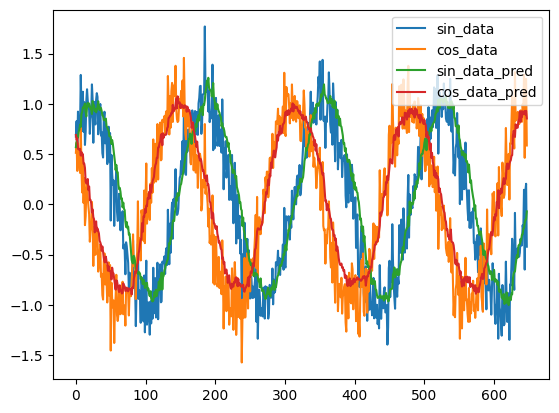

In [104]:
# Plot training data and predictions
train_labels_and_preds = pred_and_plot(model=timellm,
                                       dataset=train_df)
train_labels, train_preds = train_labels_and_preds

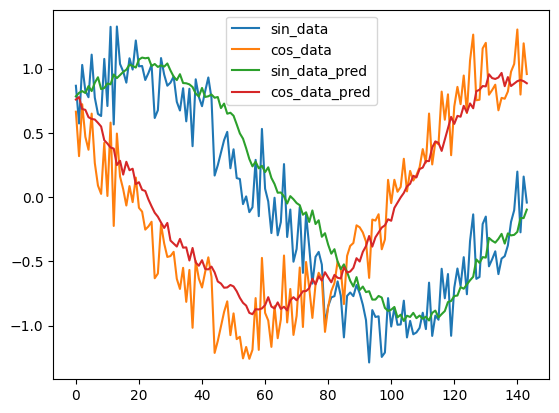

In [105]:
# Plot test data and predictions
test_label_and_preds = pred_and_plot(model=timellm,
                                     dataset=test_df)
test_label, test_preds = test_label_and_preds

## 7. Prompt-as-Prefix Ablation

We've just trained our first timellm model! Let's do a quick ablation (with and without prompt as prefix) to study the impact of the prompt on the model's predictive power.

### 7.1 Create a new instance of TimeLLM model without prompt as prefix

In [106]:
# Create an instance of TimeLLM without prompt
timellm_without_prompt = TimeLLM(checkpoint="distilgpt2",
                                 num_channels=2,
                                 window_size=24,
                                 forecast_horizon=1,
                                 patch_size=2,
                                 stride=2,
                                 torch_dtype=torch.float32,
                                 vocab_size=50257,
                                 hidden_size=768,
                                 prompt_as_prefix=None).to(DEVICE) # send the model to gpu

### 7.2 Setup optimizer and loss function

In [107]:
# Setup optimizer and loss function
optimizer = torch.optim.Adam(params=timellm_without_prompt.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.MSELoss()

### 7.3 Train the model

In [108]:
# Train our timellm model
result_without_prompt = train(model=timellm_without_prompt,
                              train_dataloader=train_dataloader_custom,
                              test_dataloader=test_dataloader_custom,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              epochs=10,
                              device=DEVICE)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2792 | test_loss: 0.2041 | 
Epoch: 2 | train_loss: 0.1625 | test_loss: 0.1095 | 
Epoch: 3 | train_loss: 0.0928 | test_loss: 0.0887 | 
Epoch: 4 | train_loss: 0.1211 | test_loss: 0.1025 | 
Epoch: 5 | train_loss: 0.0871 | test_loss: 0.1070 | 
Epoch: 6 | train_loss: 0.0766 | test_loss: 0.0507 | 
Epoch: 7 | train_loss: 0.0708 | test_loss: 0.0599 | 
Epoch: 8 | train_loss: 0.0564 | test_loss: 0.0733 | 
Epoch: 9 | train_loss: 0.0701 | test_loss: 0.0803 | 
Epoch: 10 | train_loss: 0.0673 | test_loss: 0.0535 | 


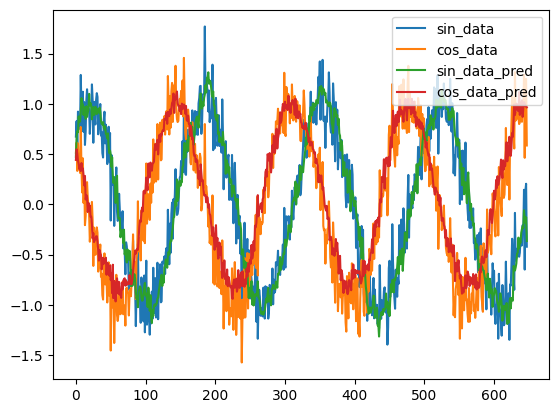

In [109]:
# Plot training data and predictions
train_labels_and_preds = pred_and_plot(model=timellm_without_prompt,
                                       dataset=train_df)
train_labels, train_preds = train_labels_and_preds

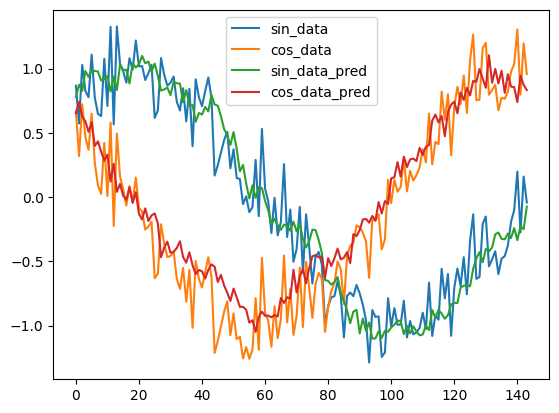

In [110]:
# Plot test data and predictions
test_label_and_preds = pred_and_plot(model=timellm_without_prompt,
                                     dataset=test_df)
test_label, test_preds = test_label_and_preds

## 8. Comparing the results

Let's compare the ablation results (with and without prompt):
* Convergence speed: The prompt-augmented model converges much faster. The no-prompt model reaches its best test loss of 0.0507 by epoch 3, whereas the prompt-augmented model reaches a similar level (even lower) of test loss (0.0502) by epoch 3.
* Forecast Accuracy: The prompt-augmented model also gives more robust forecasts. Its minimum test loss outperforms the no-prompt model (0.0481 vs 0.0502). This suggests the information in the prompt, e.g. telling the model about underlying DGP's periodicity and noise distribution, instructing the model to focus on learning the dominant periodic patterns, helps improves the predictions. Whereas the no-prompt model seems to overfit the noise in the training data, we can tell by the difference in the smoothness of the prediction curves.

